# Data inspector

## 0. Imports

In [1]:
#To be at project directory root and not in the Notebooks folder
%cd /storage2/mwildi/myLBS

#Imports
import lmdb
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import random
from collections import Counter
import cv2
from bird_view.utils.image_utils import CoordinateConverter

/storage2/mwildi/myLBS


## 1. Read dataset

In [2]:
path = "datasets/datacollect/abgfbwoajd"

### 1.1 Decode dataset

In [6]:
def decode_dataset(path):
    lmdb_env = lmdb.open(path)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()

    out = dict()
    for key, value in tqdm(lmdb_cursor):
        out[key.decode("utf-8")] = value

    lmdb_cursor.close()
    return out

def decode_data(data, kind='rgb'):
    if kind == 'loc' or kind == 'rot' or kind == 'spd' or kind == 'cmd' or kind == 'cam_location':
        return np.frombuffer(data, dtype=np.float32)

    img = np.frombuffer(data, dtype=np.uint8)

    if kind == 'trafficlights':
        #return np.frombuffer(data, dtype=np.int8)
        return int.from_bytes(data, 'little')
    elif kind == 'rgb':
        img = img.reshape((160, 384, 3))
    elif kind == 'segmentation':
        img = img.reshape((160, 384))
    elif kind == 'birdview':
        img = img.reshape((96, 96, -1))
    else:
        # raise ValueError(f"Not known type {kind}. Choose from: rgb, birdview, segmentation.")
        raise ValueError("Not known type {}. Choose from: rgb, birdview, segmentation.".format(kind))

    return img

def decode_frame(step):
    data = {'rgb':None, 'segmentation': None, 'birdview': None, 'loc': None, 'rot': None, 'spd': None, 'cmd': None, 'trafficlights': None, 'cam_location': None}

    for t in data.keys():
        # d = out[f"{t}_{step:04d}"]
        d = out["{}_{:04d}".format(t, step)]
        data[t] = decode_data(d, kind=t)

    return data

5091it [00:00, 156110.06it/s]

(160, 384, 3)


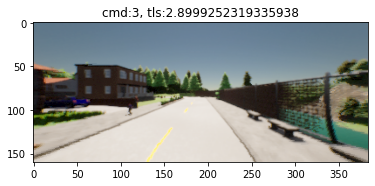

In [12]:
#print(out.keys())
out = decode_dataset(path)

assert len(out) != 0, "No data found"
step_data = decode_frame(10)
bv0=step_data['rgb']
seg=step_data['segmentation']
print(bv0.shape)
cmd = int(step_data['cmd'][0])
tls = step_data['spd'][0]
plt.title(f'cmd:{cmd}, tls:{tls}')
plt.imshow(cv2.cvtColor(bv0, cv2.COLOR_RGB2BGR))

In [ ]:
out = decode_dataset(path)
N = int(len(out.keys())/10)
print(N)
frame_range = range(N-1)
folder = '/storage2/mwildi/CBS2/Notebooks/frames'
for i in frame_range:
    step_data = decode_frame(i)
    rgb = step_data['rgb']
    cmd = int(step_data['cmd'][0])
    tls = step_data['trafficlights'][0]
    plt.title(f'cmd:{cmd}, tls:{tls}')
    plt.imshow(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
    plt.savefig(folder + "/rgb%d.png" % i)
    plt.close()
    
img_array=[]
for i in frame_range:
    img = cv2.imread(f'{folder}/rgb{i}.png')
    if img is not None:
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
out = cv2.VideoWriter(f'{folder}/vid.mp4',0x7634706d, 12, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
print('Ready!')

5091it [00:00, 102358.94it/s]


509


In [108]:
for i in range(10,30):
    loc = decode_frame(i)['loc']
    x, y, z = loc
    print('{}: {}  {} {}'.format(i,  x, y, z))
print('--------------------------')
for i in range(10,30):
    loca = decode_frame(i)['cam_location']
    x, y, z = loca
    print('{}: {}  {}  {}'.format(i,  x, y, z))
    
print('--------------------------') 
    
for i in range(10,30):
    loc = decode_frame(i)['cam_location']
    loca = decode_frame(i)['ego_location']
    ax, ay, az = loca
    x, y, z = loc
    print('{}: {}  {} {}'.format(i,  x-ax, y-ay, z-az))

TypeError: 'cv2.VideoWriter' object is not subscriptable

In [28]:
for i in range(0,1000,100):
    world_coords = decode_frame(i)['measurements']
    world_x, world_y, world_z, ori_x, ori_y, ori_z, _, _, _, cam_x, cam_y, cam_z, cam_yaw, cam_roll, cam_pitch = world_coords[:15]
    print('{}: {}  {}  {}  {}  {}  {}'.format(i,  world_x, world_y, world_z, ori_x, ori_y, ori_z))
for i in range(0,1000,100):
    print('{}: {}  {}  {}  {}  {}  {}'.format(i, cam_x, cam_y, cam_z, cam_yaw, cam_roll, cam_pitch))

KeyError: 'measurements'

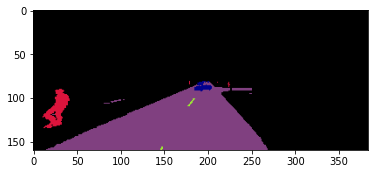

In [22]:
COLORS = [
        (102, 102, 102),
        (253, 253, 17),
        (255, 64, 64),
        (204, 6, 5),
        (0, 0, 142),
        (220, 20, 60),
        (255,0,0),
        (0,255,0),
        (0,0,0),
        (255,255,255),
        (0,255,128),
        (0,128,255),
        ]

SEM_COLORS = {
    4 : (220, 20, 60),
    5 : (153, 153, 153),
    6 : (157, 234, 50),
    7 : (128, 64, 128),
    8 : (244, 35, 232),
    10: (0, 0, 142),
    18: (220, 220, 0),
}

def viz_bv(birdview, no_show=[], num_channels=10):
    h, w = birdview.shape[:2]
    canvas = np.zeros((h, w, 3), dtype=np.uint8)
    canvas[...] = BACKGROUND

    for i in range(num_channels):
        if i in no_show:
            continue
        canvas[birdview[:,:,i] > 0] = COLORS[i]

    return canvas

def viz_sem(sem, labels=[4,6,7,10,18]):
    canvas = np.zeros(sem.shape+(3,), dtype=np.uint8)
    for label in labels:
        canvas[sem==label] = SEM_COLORS[label]
    return canvas


plt.imshow(viz_sem(seg))

### 1.2 Explore dataset

### 1.2 Inspect traffic lights state

In [16]:
N_STEPS = 70
GAP = 5

bv=decode_frame(id_frame)['birdview']
print(bv.shape[0:2])
b=np.zeros(bv.shape[0:2])
for k in range(bv.shape[2]):
    b[bv[:,:,k] != 0] = k
plt.imshow(b)
plt.axis('off')

PIXELS_PER_METER = 4
locs = []

for i in range(N_STEPS):
    world_coords = decode_frame(id_frame +GAP*i)['measurements']
    world_x, world_y, world_z, ori_x, ori_y, ori_z, _, _, _, cam_x, cam_y, cam_z, cam_yaw, cam_roll, cam_pitch = world_coords[:15]
    loc = [world_x, world_y]
    locs.append(loc)
    
locs = np.array(locs)
#dloc is the position of the next 5 waypoints w.r.t the current position
dloc = (locs[1:] - locs[0:1])
dloc = dloc*PIXELS_PER_METER - [0-320/2,-320/2]
for i in range(N_STEPS-1):
    plt.scatter(dloc[i,1], dloc[i,0], s=10)

KeyError: 'rgb_0155'

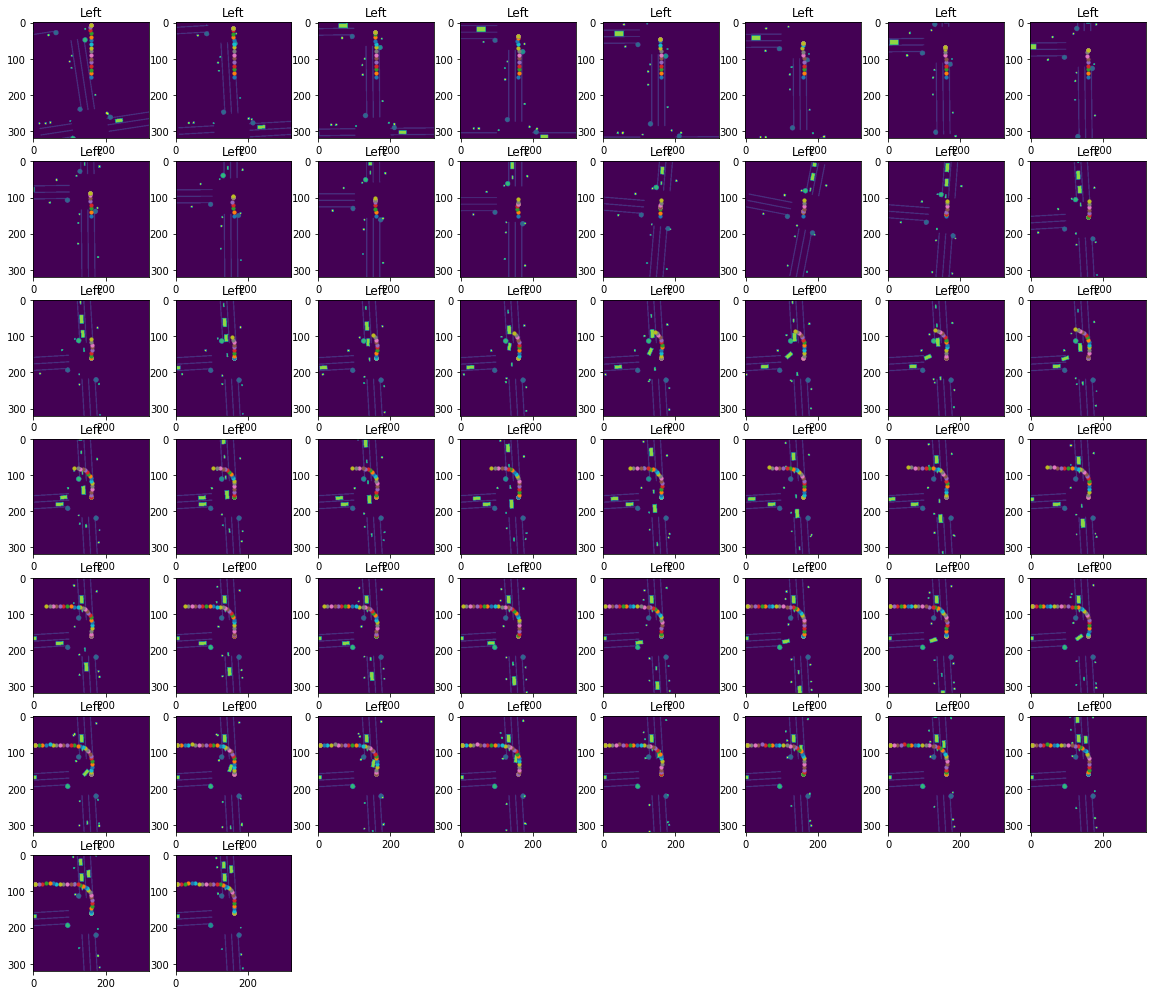

In [6]:
import math
N_STEPS = 50
GAP = 5
img_size = 320
cmds = ['None','Left', 'Right', 'Straight', 'Follow']

plt.figure(figsize=(20,20)) # specifying the overall grid size

for i in range(N_STEPS):
    grid = math.ceil(math.sqrt(N_STEPS))
    plt.subplot(grid,grid,i+1)    # the number of images in the grid is 5*5 (25)
    bv=decode_frame(id_frame +GAP*i)['birdview']
    b=np.zeros(bv.shape[0:2])
    for k in range(bv.shape[2]):
        b[bv[:,:,k] != 0] = k
    plt.imshow(b)
    
    locs = []
    for j in range(N_STEPS):
        world_coords = decode_frame((id_frame +GAP*i) + GAP * j)['measurements']
        world_x, world_y, world_z, ori_x, ori_y, ori_z, _, _, _, cam_x, cam_y, cam_z, cam_yaw, cam_roll, cam_pitch = world_coords[:15]
        loc = [world_x, world_y]
        locs.append(loc)
    locs = np.array(locs)
    #dloc is the position of the next 5 waypoints w.r.t the current position
    dloc = (locs[1:] - locs[0:1])
    dloc = dloc*PIXELS_PER_METER + [-img_size/2, img_size/2] # origin is current position of vehicle, that is why we have dloc from current position
    for i in range(N_STEPS-1):
        x = dloc[i,1]
        y = dloc[i,0]
        plt.scatter(x, -y, s=10)
    plt.title(cmds[int(decode_frame(id_frame +GAP*i)['measurements'][18])])
plt.show()

In [7]:
locs[0:1]

array([[137.74292,  58.8854 ]], dtype=float32)

## 2. Waypoints computation

### 2.1 Tools for transformations

In [8]:
class Location():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __repr__(self,):
        return self.__str__()

    def __str__(self,):
        return "Location(x={}, y={}, z={})".format(self.x, self.y, self.z)

class Rotation():
    def __init__(self, p, y, r):
        self.pitch = p
        self.yaw = y
        self.roll = r

    def __repr__(self,):
        return self.__str__()

    def __str__(self):
        return "Rotation(pitch={}, yaw={}, roll={})".format(self.pitch, self.yaw, self.roll)

class Transform():
    def __init__(self, loc, rot):
        self.location = loc
        self.rotation = rot

    def __repr__(self,):
        return self.__str__()

    def __str__(self,):
        return "Transform({}, {})".format(self.location, self.rotation)

### 2.2 Compute waypoints

In [23]:
def project_vehicle(x, y, z, ori_x, ori_y, ori_z):
    pos = np.array([x,y,z])
    ori = np.array([ori_x, ori_y, ori_z])
    ori /= np.linalg.norm(ori)  # Make unit vector

    new_pos = pos + 4 * ori
    return converter.convert(np.array([new_pos]))

def interpolate_waypoints(points):
    points = points[:, :2]

    # Fit cubic function through points
    z = np.polyfit(points[:, 0], points[:, 1], 2)
    p = np.poly1d(z)

    # Keep interpolating until we have 5 points
    while points.shape[0] < 5:
        points_2 = np.vstack([points[0], points[:-1]])
        max_id = np.argmax(np.linalg.norm(points-points_2, axis=1))
        _x = np.mean([points[max_id], points_2[max_id]], axis=0)[0]
        points = np.insert(points, max_id, np.array([_x, p(_x)]), 0)

    return points

def get_waypoints(REF_FRAME, world_x, world_y, world_z, ori_x, ori_y, ori_z, GAP=5):
    if decode_frame(REF_FRAME)['trafficlights']:
        vehicle_proj = project_vehicle(world_x, world_y, world_z, ori_x, ori_y, ori_z)
        output = np.array([vehicle_proj[0] for _ in range(5)])
        return output

    output = []
    for i in range(REF_FRAME, (REF_FRAME + (N_STEP+1+BUFFER*GAP)), GAP):
        if len(output) == N_STEP:
            break

        x, y, z = decode_frame(i)['measurements'][:3]
        image_coords = converter.convert(np.array([[x, y, z]]))
        if len(image_coords) > 0:
            output.append(image_coords[0])

    if len(output) < 2:
        # First try with smaller GAP
        if GAP == 5:
            return get_waypoints(REF_FRAME, world_x, world_y, world_z, ori_x, ori_y, ori_z, GAP=1)

        vehicle_proj = project_vehicle(world_x, world_y, world_z, ori_x, ori_y, ori_z)
        output = np.array([vehicle_proj[0] for _ in range(5)])
        return output

    if len(output) >= 2 and len(output) < 5:
        return interpolate_waypoints(np.array(output))

    return np.array(output)

In [24]:
N_STEP = 5
BUFFER = 40
N_DATASET_CATEGORIES = 9 #(used to be 7)

np.set_printoptions(suppress=True)

all_wp = []
N = int((len(out)-1)/N_DATASET_CATEGORIES) - 1

for frame in tqdm(range(N - (N_STEP * BUFFER) - 1)):
        # Extract world coordinates from dataset
        world_coords = decode_frame(frame)['measurements']
        world_x, world_y, world_z, ori_x, ori_y, ori_z, _, _, _, cam_x, cam_y, cam_z, cam_yaw, cam_roll, cam_pitch = world_coords[:15]

        sensor_transform = Transform(Location(cam_x, cam_y, cam_z), Rotation(cam_yaw, cam_roll, cam_pitch))
        #print('Cam {} {} {} {} {} {}'.format(cam_x, cam_y, cam_z, cam_yaw, cam_roll, cam_pitch))
        converter = CoordinateConverter(sensor_transform, fov=120)

        image_coord_wp = get_waypoints(frame, world_x, world_y, world_z, ori_x, ori_y, ori_z)

        all_wp.append(image_coord_wp[:, :2])

100%|█████████████████████████████████████| 1177/1177 [00:01<00:00, 1087.01it/s]


## 4. Final results

### 4.1 View final results

In [25]:
def plot_results(ref_frame_id, locations):
    plt.figure(figsize=(20,12))
    plt.title("REF FRAME ({}) WITH PROJECTIONS".format(ref_frame_id))
    plt.imshow(decode_frame(ref_frame_id)['segmentation'][:, :, 0])
    for i, location in enumerate(locations):
        plt.scatter(location[:, 0], location[:, 1], label="projection {}".format(i))
    plt.legend()
    plt.show()

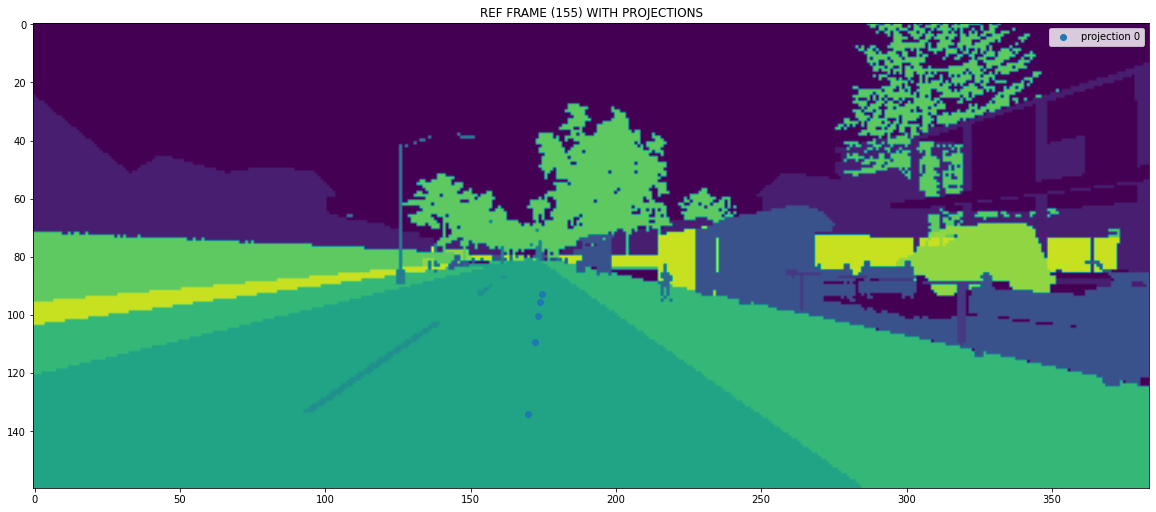

In [26]:
plot_results(155, [all_wp[155]])